In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from jeeves.cross_validation import report_stratifiedKfold_cv
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydot
%matplotlib inline

In [2]:
df = pd.read_table("tagged.tsv")

In [3]:
categoricals = []
for col in "section target_audience type".split():
    categoricals.append(pd.get_dummies(df[col]))
dfCat = pd.concat(categoricals, axis=1)

In [4]:
dfBool = df['speaker_link_present content_url_present'.split()].astype(int)

In [5]:
dfNum = df['n_votes n_comments deadlinediff'.split()]

In [6]:
feats = [dfCat, dfBool, dfNum]

In [7]:
X = pd.concat(feats, axis=1)
y = df['selected'].astype(int).values

In [8]:
savemat("trainData.mat", dict(X=X.values, y=y, cols=X.columns.values))

In [9]:
xabs = X.copy()
xabs['deadlinediff'] = xabs.deadlinediff.abs()

In [14]:
report_stratifiedKfold_cv(DecisionTreeClassifier(min_samples_leaf=2), xabs.values, y, shuffle=True, n_folds=10)

,accuracy_score,recall_score
0,0.966667,1.000000
1,0.866667,0.571429
2,0.900000,0.571429
3,0.800000,0.714286
4,0.931034,0.833333
5,0.821429,0.666667
6,0.892857,0.833333
7,0.892857,0.833333
8,0.928571,0.666667
9,0.821429,0.333333


In [12]:
param_grid = dict(
    criterion=["entropy"], splitter="best random".split(),
    max_features=[None, "auto", "sqrt", "log2"],
    class_weight=["balanced", None],
    presort=[True, False],
    min_samples_leaf=np.arange(1, 6)
)
clf = DecisionTreeClassifier()
gcv = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)

In [13]:
gcv.fit(X.values, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'presort': [True, False], 'splitter': ['best', 'random'], 'criterion': ['entropy'], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'class_weight': ['balanced', None], 'min_samples_leaf': array([1, 2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [14]:
gcv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': None,
 'min_samples_leaf': 2,
 'presort': False,
 'splitter': 'best'}

In [15]:
gcv.best_score_

0.87889273356401387

In [11]:
clf = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=2)

In [53]:
X_nondead = X[[c for c in X if c!="deadlinediff"]]

In [15]:
report_stratifiedKfold_cv(clf, xabs.values, y, n_folds=10).mean()

accuracy_score    0.863235
recall_score      0.695238
dtype: float64

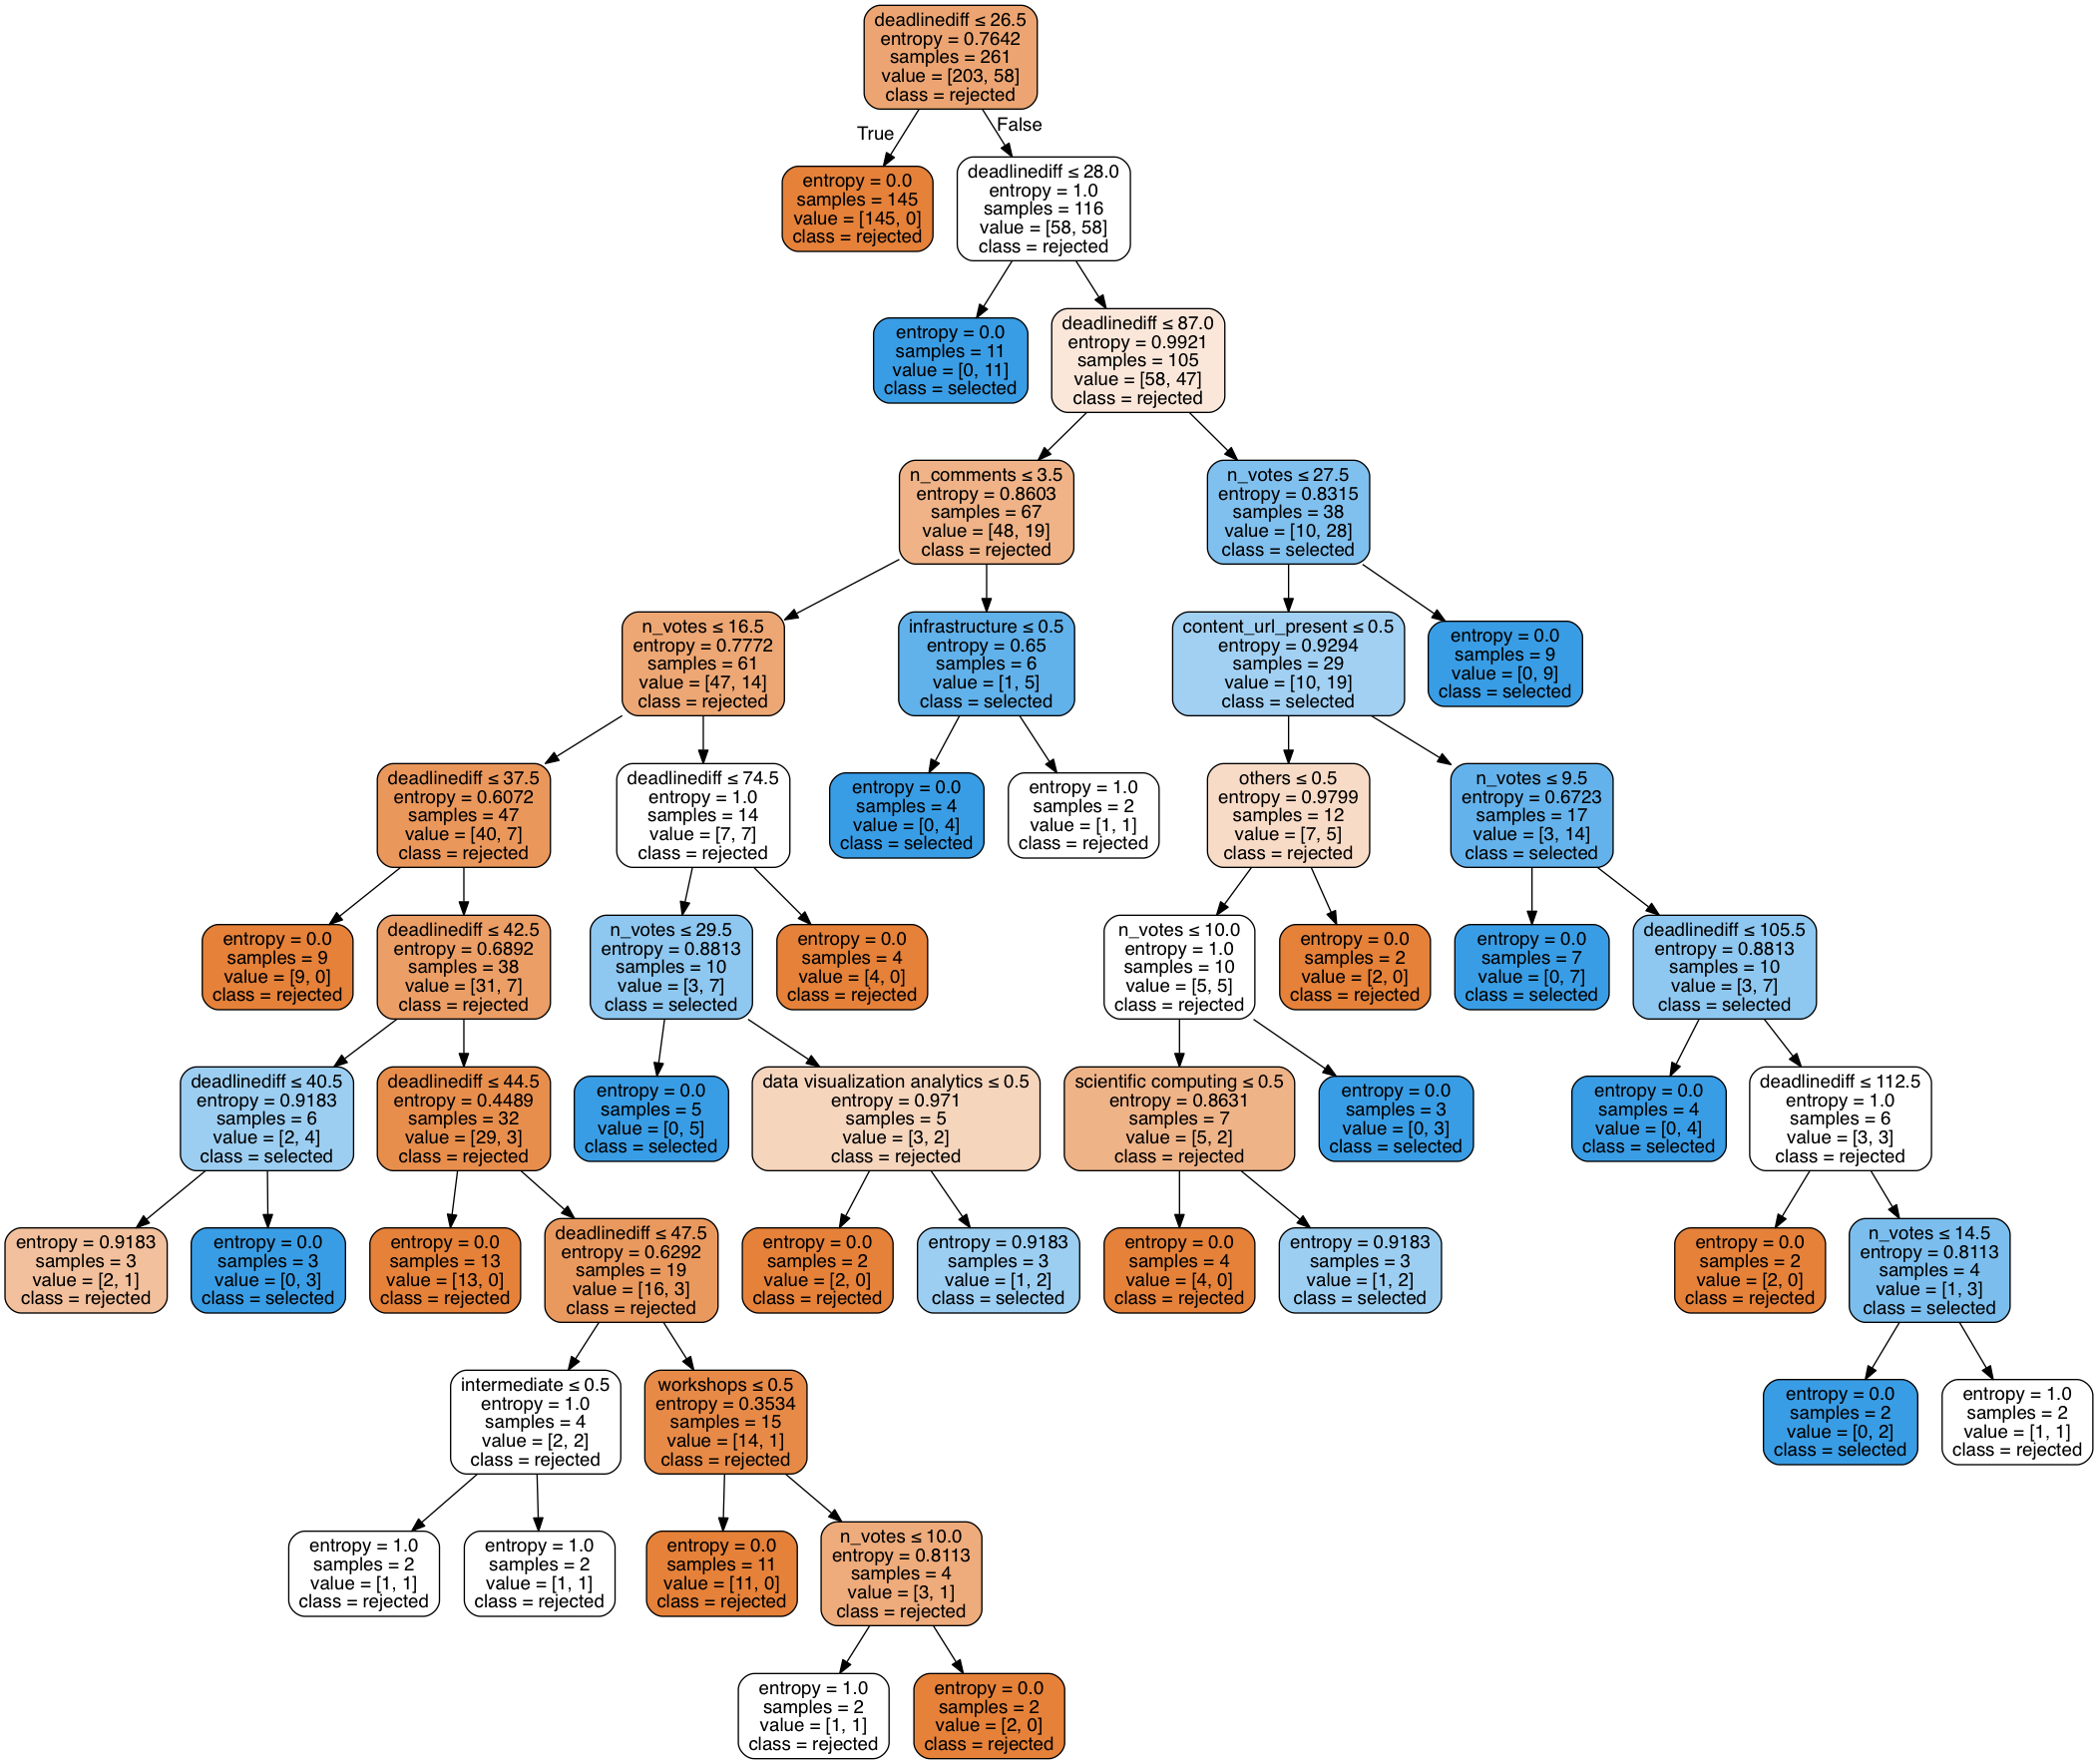

In [16]:
dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data,  
                feature_names=xabs.columns,  
                class_names=['rejected', 'selected'],  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [17]:
preds = clf.predict(xabs.values)

In [18]:
from sklearn.metrics import recall_score, precision_score, precision_recall_curve
print recall_score(y, preds)
print precision_score(y, preds)

0.890625
0.934426229508


In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
confusion_matrix(y, preds)

array([[221,   4],
       [  7,  57]])

In [23]:
from sklearn.metrics import roc_curve

In [24]:
roc_curve?

In [78]:
pp = clf.predict_proba(X.values)[:, 1]

In [79]:
fpr, tpr, _ = roc_curve(y, pp)

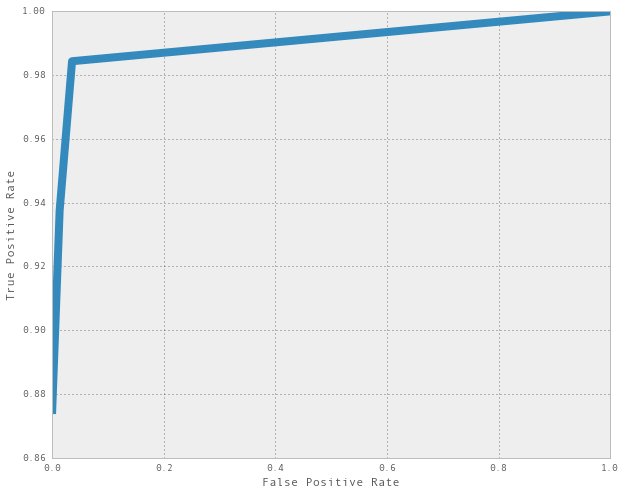

In [80]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
roc_auc_score(y, pp)

0.98802083333333335

In [30]:
precision_recall_curve?

In [31]:
p, r, _ = precision_recall_curve(y, pp)

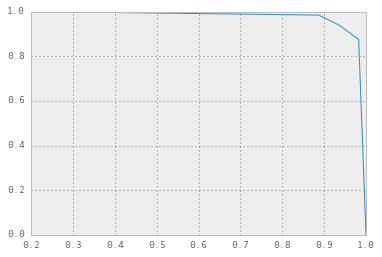

In [32]:
plt.plot(p, r)

In [33]:
# Final Verification

In [41]:
df[X.deadlinediff > -25.5].selected.value_counts()

False    187
True       1
Name: selected, dtype: int64

In [46]:
df[X.deadlinediff > -44.5].selected.value_counts()

False    205
True      25
Name: selected, dtype: int64